# Download Dependencies for PyTorch Geometry

In [1]:
! python -c "import torch; print(torch.__version__)"
! python -c "import torch; print(torch.cuda.is_available())"

1.4.0
True


In [6]:
#! PATH=/usr/local/cuda/bin:$PATH
#! CPATH=/usr/local/cuda/include:$CPATH    
#! LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
#! DYLD_LIBRARY_PATH=/usr/local/cuda/lib:$DYLD_LIBRARY_PATH

In [3]:
! nvcc --version
! python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89
10.1


In [5]:
#drive = GoogleDrive(gauth)
#your_module = drive.CreateFile({"id": "14IsXaDx2MIjEhqrTe-WIkb5Pe0RIMLwi"})   # "your_module_file_id" is the part after "id=" in the shareable link
#your_module.GetContentFile("setup.py")          # Save the .py module file to Colab VM
#import setup 

In [4]:
# Install PyTorch Geometry 
#! pip install --no-cache-dir torch-scatter
#! pip install --no-cache-dir torch-sparse
#! pip install --no-cache-dir torch-cluster
#! pip install --no-cache-dir torch-spline-conv (optional)
#! pip install torch-geometric

In [7]:
# Install RDKit
# takes 2-3 minutes
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

# Regular Imports

In [8]:
from __future__ import division
from __future__ import unicode_literals

import sys
import random 
import re

sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import logging
import torch
#from torch_geometric.data import Data
from torch_geometric.data import DataLoader


from sklearn.model_selection import train_test_split


from IPython.display import SVG
from itertools import product
import copy

RDKit WARNING: [10:45:12] Enabling RDKit 2019.09.3 jupyter extensions


# Create Graphs

In [9]:
import numpy as np
import multiprocessing
import logging
import torch
from torch_geometric.data import Data

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))
 

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 

def get_intervals(l):
    """For list of lists, gets the cumulative products of the lengths"""
    intervals = len(l) * [0]
    # Initalize with 1
    intervals[0] = 1
    for k in range(1, len(l)):
        intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
 
    return intervals
 

def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        return len(l)
 
 
possible_atom_list = ['C', 'N', 'O', 'S', 'F', 'H']
possible_numH_list = [0, 1, 2, 3, 4]
possible_valence_list = [0, 1, 2, 3, 4, 5, 6]
possible_formal_charge_list = [-3, -2, -1, 0, 1, 2, 3]
possible_hybridization_list = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_number_radical_e_list = [0, 1, 2]
possible_chirality_list = ['R', 'S']
 
reference_lists = [
    possible_atom_list, possible_numH_list, possible_valence_list,
    possible_formal_charge_list, possible_number_radical_e_list,
    possible_hybridization_list, possible_chirality_list
]
 
intervals = get_intervals(reference_lists)
 

def get_feature_list(atom):
    features = 6 * [0]
    features[0] = safe_index(possible_atom_list, atom.GetSymbol())
    features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
    features[2] = safe_index(possible_valence_list, atom.GetImplicitValence())
    features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())
    features[4] = safe_index(possible_number_radical_e_list,
                           atom.GetNumRadicalElectrons())
    features[5] = safe_index(possible_hybridization_list, atom.GetHybridization())
    return features
 
    
def features_to_id(features, intervals):
    """Convert list of features into index using spacings provided in intervals"""
    id = 0
    for k in range(len(intervals)):
        id += features[k] * intervals[k]
 
    # Allow 0 index to correspond to null molecule 1
    id = id + 1
    return id
 

def id_to_features(id, intervals):
    features = 6 * [0]
 
    # Correct for null
    id -= 1
 
    for k in range(0, 6 - 1):
        # print(6-k-1, id)
        features[6 - k - 1] = id // intervals[6 - k - 1]
        id -= features[6 - k - 1] * intervals[6 - k - 1]
    # Correct for last one
    features[0] = id
    return features
 

def atom_to_id(atom):
    """Return a unique id corresponding to the atom type"""
    features = get_feature_list(atom)
    return features_to_id(features, intervals)
 

def atom_features(atom, bool_id_feat=False, explicit_H=False,
                  use_chirality=False):
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
   
    else:
        from rdkit import Chem
        # Atom type - one hot encoding
        results = one_of_k_encoding(atom.GetSymbol(), ['C', 'N', 'O', 'S', 'F', 'H']) # use unk if it fails
        
        # Directly bonded neighbors
        results += one_of_k_encoding(atom.GetDegree(), [1, 2, 3, 4]) # use unk if it fails 
        
        # Return number of implicit Hs on atom
        results += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3]) # use unk if it fails
        
        # Atom's formal charge
        results += [atom.GetFormalCharge()]
        
        # Number of radical electrons
        #results += [atom.GetNumRadicalElectrons()]
        
        # Atom Hybridization
        results += one_of_k_encoding(atom.GetHybridization(), [
                        Chem.rdchem.HybridizationType.SP,
                        Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3])
        
        # Aromatic or not?
        results +=[atom.GetIsAromatic()]
        
        
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
                atom.GetProp('_CIPCode'),
                ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]
 
    return np.array(results)
 
    
def bond_features(bond, use_chirality=False):
    from rdkit import Chem
    bt  = bond.GetBondType() # bond type
    
    # Bond order
    bond_feats = [bt == Chem.rdchem.BondType.SINGLE, 
                  bt == Chem.rdchem.BondType.DOUBLE,
                  bt == Chem.rdchem.BondType.TRIPLE,
                  bt == Chem.rdchem.BondType.AROMATIC]
    
    # Conjugated bond
    bond_feats += [bond.GetIsConjugated()]
    
    # Is the bond in a ring?
    bond_feats += [bond.IsInRing()]
    
    # Check chirality
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    
    return np.array(bond_feats)
 

#################
# pen added
#################


def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res
 
def mol2vec(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features(atom,) for atom in atoms]
    
    edge_index = get_bond_pair(mol)
    #print(edge_index)
    edge_attr = [bond_features(bond) for bond in bonds]*2
    
    data = Data(x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr,dtype=torch.float)
                )
    return data

## Test

In [10]:
smiles = 'c1ccc(cc1)[N+](=O)[O-]'
mol = Chem.MolFromSmiles(smiles)

mol2vec(mol)


Data(edge_attr=[18, 6], edge_index=[2, 18], x=[9, 24])

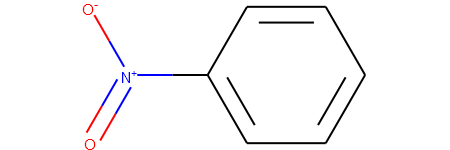

In [11]:
mol

# My net

## Split training/testing and Create Graphs

In [12]:

def make_graph(x):
    
    smi, energy = x
    
    mol = Chem.MolFromSmiles(smi)
    graph = mol2vec(mol)
    graph.y = energy
    
    return graph

def create_graphs(df, prop='tbr', procs=4):
    """ Creates graph from dataframe, and sets target values """
    
    graph_list = []
    
    for smi, energy in zip(df.smiles.tolist(), df[prop].tolist()):
        mol = Chem.MolFromSmiles(smi)
        graph = mol2vec(mol)
        graph.y = energy
        
        graph_list.append(graph)
    
    return graph_list

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')

In [14]:
sys.path.append('C:/Users/jacob/tQMC/QMC')
from qmconf import QMConf
from qmmol import QMMol

In [15]:
# df = pd.read_pickle('/content/drive/My Drive/Kemi på KU/result_updated.pkl')

# compound_list = list()
# for x in df.itertuples():
#   name = str(x.prod.label.split('_p')[0])
#   #mol = Chem.RemoveHs(x.prod.get_rdkit_mol())
#   mol = x.prod.get_rdkit_mol()
#   smile = Chem.MolToSmiles(mol,isomericSmiles=False)
#   compound_list.append({'comp_name': name, 'smiles': smile, 'storage': x.storage, 'tbr': x.tbr})
  
# data = pd.DataFrame(compound_list)
# #data.head()

In [16]:
# # remove bad data
# gcnn_data = data
# gcnn_data = gcnn_data[gcnn_data['storage'] > 0.0]
# gcnn_data = gcnn_data[gcnn_data['storage'] < 200.]

# gcnn_data.to_pickle('/content/drive/My Drive/Colab Notebooks/new_result2_updated.pkl')
# f"total data set size: {gcnn_data.shape[0]}"

In [17]:
gcnn_data = pd.read_pickle('result_abs2.pkl')
gcnn_data.head()

,comp_name,smiles,storage,tbr,absorp
0,A-0_A-0_A-0_A-0,[H]C1([H])C2([H])C3([H])C2([H])C2([H])C1([H])C...,8.111205,320.298085,159.7
1,A-1_A-0_A-0_A-0,[H]C1([H])C2([H])C3([H])C2([H])C2(F)C1([H])C32[H],22.362574,290.434249,177.7
2,A-2_A-0_A-0_A-0,[H]C1([H])C2([H])C3([H])C2([H])C2(C(F)(F)F)C1(...,7.536407,284.936736,167.8
3,A-3_A-0_A-0_A-0,[H]C1([H])C2([H])C3([H])C2([H])C2(C#N)C1([H])C...,9.834636,258.947101,220.8
4,A-4_A-0_A-0_A-0,[H]C1([H])C2([H])C3([H])C2([H])C2([N+](=O)[O-]...,5.430744,219.128675,295.2


In [18]:
gcnn_data.drop_duplicates(subset = "smiles", keep = 'first', inplace = True)

In [19]:
gcnn_data.shape

(33706, 5)

In [20]:
# split data into training and testing

df_ns = gcnn_data.copy()
test_size_20 = int(df_ns.shape[0]*0.2) #dataset split is 80/20


gcnn_test = df_ns.sample(test_size_20, random_state=42)
gcnn_train = df_ns.drop(gcnn_test.index)
  
f"train size: {gcnn_train.shape[0]}, test size: {gcnn_test.shape[0]}"    

'train size: 26965, test size: 6741'

In [21]:
import time

t = time.time()
#test_graphs = create_graphs(gcnn_test)
#print(f"test graphs DONE in {time.time()-t}")

train_graphs = []
for i, df in enumerate(np.array_split(gcnn_train, 8)):
    t = time.time()
    tmp_list = create_graphs(df)
    train_graphs += tmp_list
    print(f"{i+1} of 8 DONE in {time.time()-t}")
    
# select 10% samples for validating the method during traning
num_val_samples = round(len(train_graphs) * 0.10)
val_samples = [train_graphs.pop(random.randrange(len(train_graphs))) for _ in range(num_val_samples)]

1 of 8 DONE in 4.052105665206909
2 of 8 DONE in 4.9256751537323
3 of 8 DONE in 4.556952476501465
4 of 8 DONE in 6.652397632598877
5 of 8 DONE in 5.748921871185303
6 of 8 DONE in 5.036317586898804
7 of 8 DONE in 4.504965543746948
8 of 8 DONE in 5.700973749160767


In [22]:
bs_model = 512

train_loader = DataLoader(train_graphs, batch_size=bs_model, shuffle=True, drop_last=True)
test_loader = DataLoader(gcnn_test, batch_size=bs_model, shuffle=True, drop_last=True)
val_loader =  DataLoader(val_samples, batch_size=bs_model, shuffle=True, drop_last=True)

In [23]:
len(val_samples)

2696

## Define Net and Train

In [24]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.nn import BatchNorm1d
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
from torch.nn import Linear, CELU
import torch.nn.functional as F

In [25]:
n_features = 24 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(n_features, 128)
        self.bn1 = BatchNorm1d(128)
        
        
        self.conv2 = GCNConv(128,64)
        self.bn2 = BatchNorm1d(64)
        
        #self.fc1 = Linear(64,32)
        #self.bn3 = BatchNorm1d(32) 
        self.fc1 = Linear(64,64) #new
        self.bn3 = BatchNorm1d(64) #new

        #self.fc2 = Linear(32,32)
        #self.drop_layer = nn.Dropout()
        #self.fc3 = Linear(32,1)
        self.fc2 = Linear(64,1) #new
        
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        
        x = global_max_pool(x, data.batch)
        
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.fc2(x)
        #x = F.relu(self.fc2(x))
        
        #x = F.dropout(x, training=self.training)
        
        
        #x = self.fc3(x)
        
        return x
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
count_parameters(model)

16193

In [26]:
def train(epoch, loader):
    model.train()
    
    loss_all = 0
    count = 0
    for data in loader:
        optimizer.zero_grad()
        
        # transform data
        data = data.to(device)
        real_y = data.y.to(device).type("torch.cuda.FloatTensor")
        
        # predict 
        predicted = model(data)
        
        # compute loss 
        loss = torch.nn.MSELoss()(predicted.reshape([bs_model]), real_y)
        loss_all += loss
        count += 1
        
        # update step
        loss.backward()
        optimizer.step()
    
    loss_all = loss_all / count
    return  loss.item()
    

def test(loader):
    model.eval()
    
    pred_all = []
    real_all = []
    for data in loader:
        # transform data
        data = data.to(device)
        real_y = data.y.to(device).type("torch.cuda.FloatTensor")
    
        predicted = model(data).reshape([bs_model]).tolist()
    
        real_all += real_y.tolist()
        pred_all += predicted
     
    L1Loss = abs(np.array(pred_all) - np.array(real_all)).mean()
    
    return L1Loss


#def L1(pred, real):
#    return abs(np.array(pred)-np.array(real)).mean()

#def mse(pred, real):
#    s = (np.array(pred) - np.array(real))**2
#    return np.sqrt(s)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay=5e-4)

old_val_loss = 1000.
for epoch in range(1,100):
    train_loss = train(epoch, train_loader)
    val_loss = test(val_loader)
    acc_train_loss = test(train_loader)
    
    #print(f'train loss: {"{:.2f}".format(train_loss)}, L1 train loss: {"{:.2f}".format(acc_train_loss)}, val loss {"{:.2f}".format(val_loss)}') 

    # check point model with lowest val loss:
    if val_loss < old_val_loss:
        best_model_param = model.state_dict()
        old_val_loss = val_loss
        
        print(f'model saved. EPOCH: {epoch}, VAL Loss: {"{:.2f}".format(val_loss)}')
   

    # Implement some sort of convergence criteria. 

    
model = Net().to(device)
model.load_state_dict(best_model_param)    
#print(f"model trained in: {":.2f".format(time.time()-t)} s")

model saved. EPOCH: 1, VAL Loss: 164.11
model saved. EPOCH: 2, VAL Loss: 116.85
model saved. EPOCH: 3, VAL Loss: 27.31
model saved. EPOCH: 4, VAL Loss: 14.45
model saved. EPOCH: 8, VAL Loss: 11.61
model saved. EPOCH: 11, VAL Loss: 11.13
model saved. EPOCH: 12, VAL Loss: 10.09
model saved. EPOCH: 28, VAL Loss: 9.16
model saved. EPOCH: 37, VAL Loss: 8.85
model saved. EPOCH: 46, VAL Loss: 8.51
model saved. EPOCH: 61, VAL Loss: 8.28
model saved. EPOCH: 71, VAL Loss: 8.20
model saved. EPOCH: 75, VAL Loss: 7.94
model saved. EPOCH: 81, VAL Loss: 7.83


<All keys matched successfully>

In [28]:
best_model_param

OrderedDict([('conv1.weight',
              tensor([[-0.0696,  0.1596,  0.0881,  ..., -0.0950,  0.2491,  0.4279],
                      [ 0.0610, -0.1419,  0.5078,  ...,  0.1376,  0.4225, -0.3056],
                      [-0.0966,  0.0670,  0.0260,  ..., -0.2484, -0.3181, -0.0040],
                      ...,
                      [ 0.0347, -0.1057, -0.0139,  ...,  0.3100, -0.5102, -0.6419],
                      [-0.2388,  0.0954,  0.1060,  ..., -0.0014,  0.0791, -0.1525],
                      [-0.1845,  0.0776,  0.1925,  ..., -0.1983,  0.0292, -0.1850]],
                     device='cuda:0')),
             ('conv1.bias',
              tensor([-0.1647,  0.1299,  0.1058, -0.1186, -0.0601, -0.0974, -0.0496, -0.0917,
                       0.1183,  0.0000, -0.0601, -0.3254, -0.0604, -0.0807, -0.2520, -0.1937,
                      -0.1436, -0.1067, -0.1209, -0.1044, -0.0119, -0.0519,  0.0690, -0.0636,
                      -0.0814,  0.0805,  0.1681,  0.0064, -0.1499,  0.0891,  0.0904, -0.

In [36]:
torch.save(best_model_param, 'state_model_tbr_81.pt')

# Try Model

In [37]:
model.load_state_dict(torch.load('state_model_tbr_81.pt'))

def compute_energies(loader):
    model.eval()
    
    pred_all = []
    real_all = []
    for data in loader:
        # transform data
        data = data.to(device)
        real_y = data.y.to(device).type("torch.cuda.FloatTensor")
    
        predicted = model(data).reshape([bs_model]).tolist()
    
        real_all += real_y.tolist()
        pred_all += predicted
    
    return real_all, pred_all

## Test model

In [38]:
#df_dict = dict()
df_dict = gcnn_test[gcnn_test.storage > 0.]

print(len(df_dict))

6741


### plot real vs. test

(40, 323.0)

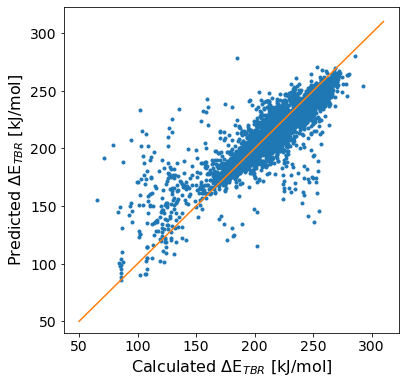

In [39]:
import matplotlib as mpl

mpl.rc({'figure.autolayout': True})
# Helvetica format and white background
mpl.rc("text.latex", preamble=["\\usepackage{helvet}\\usepackage{sfmath}"])
mpl.rc("figure", facecolor="white")
#! supscript and superscript NOT italic
mpl.rc({'mathtext.default': 'regular'})

plt.figure(figsize=(6,6))

graph_test =  [mol2vec(Chem.MolFromSmiles(x)) for x in df_dict.smiles]
for graph, energy in zip(graph_test, df_dict.tbr):
    graph.y = torch.tensor([energy], dtype=torch.float64)

tt_loader = DataLoader(graph_test, batch_size=bs_model, shuffle=True, drop_last=True)

# plot stuff
tt_real, tt_pred = compute_energies(tt_loader)

plt.plot(np.array(tt_real), np.array(tt_pred), '.')
plt.plot(np.array([50,310]), np.array([50,310]))


plt.xlabel(r'Calculated $\Delta$E$_{TBR}$ [kJ/mol]', fontsize=16), plt.ylabel(r'Predicted $\Delta$E$_{TBR}$ [kJ/mol]', fontsize=16), 
plt.tick_params(labelsize=14)
plt.ylim(bottom=40)

#plt.savefig('/content/drive/My Drive/Kemi på KU/pred_vs_true_tbr.pdf', dpi=800)

### mean + std from all

In [ ]:
mean = []
std = []

t = df_dict
    
# make graphs
ggt =  [mol2vec(Chem.MolFromSmiles(x)) for x in t.smiles]
for graph, energy in zip(ggt, t.tbr):
    graph.y = torch.tensor([energy], dtype=torch.float64)
t_loader = DataLoader(ggt, batch_size=bs_model, shuffle=True, drop_last=True)
    
    
# predict values
t_real, t_pred = compute_energies(t_loader)
    
# compute mean and std
mae = abs(np.array(t_pred) - np.array(t_real)).mean()
mae_error = abs(np.array(t_pred) - np.array(t_real)).std()
    
mean.append(mae)
std.append(mae_error)
    

mean = np.array(mean)
std = np.array(std)
print(mean, std)

[7.60674119] [10.66022447]


             comp_name  ...         tbr
11559  A-2_A-9_A-0_A-0  ...  303.282839

[1 rows x 4 columns]


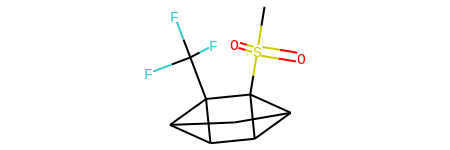

In [ ]:
maximum = t['tbr'] == max(t.tbr)
smile = t[maximum].smiles
print(t[maximum])

Chem.MolFromSmiles(str(smile.to_list()[0]))
